# Homework 7 - Vector Autoregression (VAR)

The Federal Reserve sets the ‘federal funds rate’ during their regular board of governors’ meetings. The federal funds rate is the interbank lending interest rate and setting it by the Federal Reserve is referred to as the government’s monetary policy. Our goal is to evaluate the effect of monetary policy on inflation and unemployment rates in the US.


Build a vector autoregressive (VAR) model of the US economy by considering the interactions among 
1) unemployment rate, 
2) inflation rate, and 
3) federal funds rate. 



a) Check for stationarity of the variables and determine whether you need to transform any of the variables before using it in the VAR.

b) Select the order of the VAR model using the information criteria method.

c) Estimate the VAR model and interpret the relations between the variables.

d) Evaluate the residuals and determine whether they violate any of the underlying
assumptions.

e) Split the sample into training and test (last 8 quarters) subsamples. Train the VAR model
using the training sample and forecast the original variables (i.e., invert any transformation that you may have done in part a) for 8 quarters. Compare the forecasts with the test sample and show them on a plot.

f) Compute the Mean Absolute Percentage Error (MAPE) and the Root Mean Squared Error (RMSE) for the forecasts.

g) Identify temporal ordering of the variables by using the Granger Causality test. (Hint: see the class code for week 8)

h) The US economy is currently experiencing high levels of inflation and unemployment rates. Based on your findings, what do you think the Federal Reserve should do to correct these trends?

In [7]:
# Prepare the environment for analysis and load libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from scipy.stats.distributions import chi2

from datetime import datetime, timedelta

#### Use pandas’ DataReader to download these data at quarterly frequency from FRED, from 1970 to 2019 (stop before 2020 to prevent COVID volatility from affecting your estimates).

In [8]:
# pip install pandas_datareader 
from pandas_datareader import data

# Define these objects and refer to them when calling deining limts in the data imortation process
start=datetime(1970,1,1) # from January 1 1970
end=datetime(2019,12,31) # to December 31 2019

# Import unemployment data and visualize it 
unempdata=data.DataReader('UNRATE', data_source='fred', start=start, end=end) # 
unempdata['unempgr']=unempdata.UNRATE.pct_change()*100
unemp_q=unempdata.resample('3M', axis=0).last()
unemp_q.head(3)

,UNRATE,unempgr
DATE,,
1970-01-31,3.9,NaN
1970-04-30,4.6,4.545455
1970-07-31,5.0,2.040816


In [9]:
# Import inflation data data and look at the head of the data 
inflatdata=data.DataReader('FLEXCPIM679SFRBATL', data_source='fred', start=start, end=end)
inflat_q=inflatdata.resample('3M', axis=0).last()
inflat_q.head(3)

,FLEXCPIM679SFRBATL
DATE,
1970-01-31,6.077632
1970-04-30,2.988400
1970-07-31,2.820601


In [10]:
fedfunddata=data.DataReader('FEDFUNDS', data_source='fred', start=start, end=end)
fedfund_q=fedfunddata.resample('3M', axis=0).last()
fedfund_q.head(3)

,FEDFUNDS
DATE,
1970-01-31,8.98
1970-04-30,8.10
1970-07-31,7.21


In [12]:
unemp_q.index=unemp_q.index.to_period('M').to_timestamp('M')
df=unemp_q
df['fedrate']=fedfund_q['FEDFUNDS']
df['inflat']=inflat_q['FLEXCPIM679SFRBATL']
df.head()

,UNRATE,unempgr,fedrate,inflat
DATE,,,,
1970-01-31,3.9,NaN,8.98,6.077632
1970-04-30,4.6,4.545455,8.10,2.988400
1970-07-31,5.0,2.040816,7.21,2.820601
1970-10-31,5.5,1.851852,6.20,4.140483
1971-01-31,5.9,-3.278689,4.14,2.385616


<Axes: xlabel='DATE'>

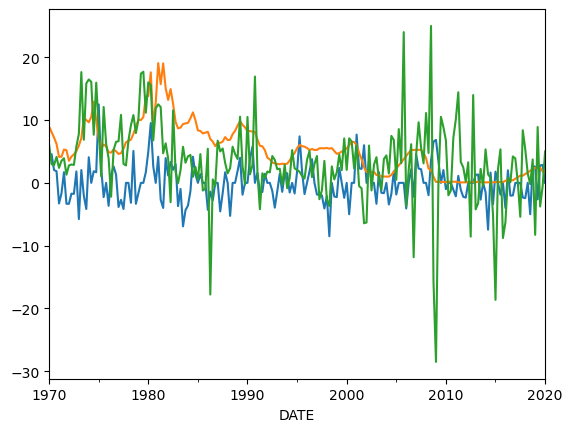

In [15]:
df.unempgr.plot()

df.fedrate.plot()

df.inflat.plot()

### Check for stationarity 

In [17]:
sts.adfuller(df.unempgr[1:])

(-5.814932891137987,
 4.314525650913839e-07,
 11,
 188,
 {'1%': -3.465620397124192,
  '5%': -2.8770397560752436,
  '10%': -2.5750324547306476},
 905.303520770794)

In [18]:
sts.adfuller(df.fedrate[1:])

(-1.7866603892176613,
 0.3871042617320931,
 9,
 190,
 {'1%': -3.4652439354133255,
  '5%': -2.8768752281673717,
  '10%': -2.574944653739612},
 575.49751244204)

In [19]:
sts.adfuller(df.inflat[1:])

(-3.406368860499943,
 0.010743664214396768,
 5,
 194,
 {'1%': -3.4645146202692527,
  '5%': -2.8765564361715534,
  '10%': -2.5747745328940375},
 1206.6657858631454)

#### The federal fund rate does not look stationary.  It has a p-value of 0.38710426173209367, which is more than the 5% confidence interval. Let's take the first difference of the federal fund rate:

<Axes: xlabel='DATE'>

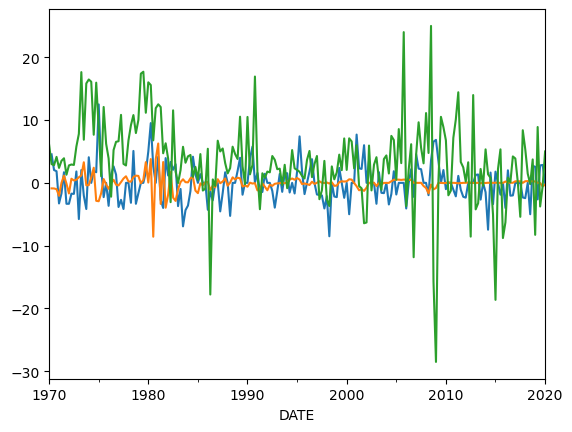

In [20]:
df['dfedrate']=df.fedrate.diff()
df.head()
df.unempgr.plot()
df.dfedrate.plot()
df.inflat.plot()

<Axes: xlabel='DATE'>

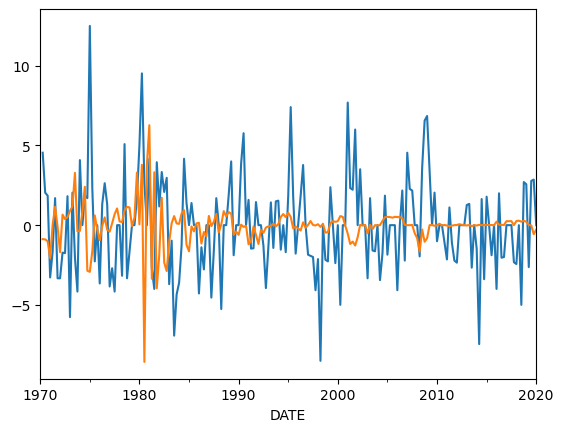

In [21]:
df.unempgr.plot()
df.dfedrate.plot()

<Axes: xlabel='DATE'>

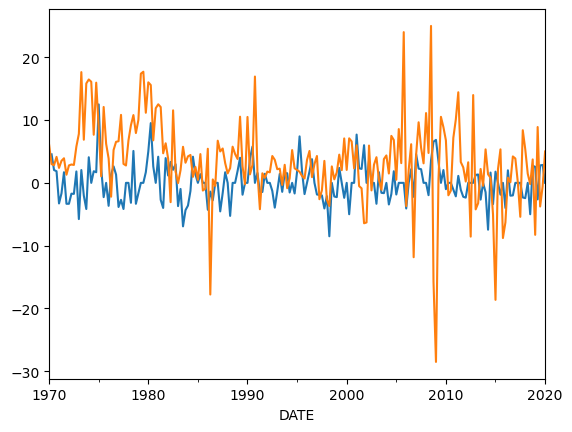

In [22]:
df.unempgr.plot()
df.inflat.plot()

<Axes: xlabel='DATE'>

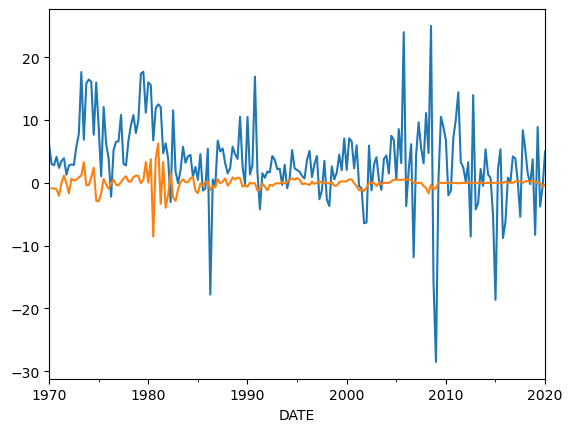

In [23]:
df.inflat.plot()
df.dfedrate.plot()

### Fitting a VAR model:

In [24]:
from statsmodels.tsa.api import VAR
# create a clean DataFrame for the VAR:
vardf=df[['unempgr', 'dfedrate', 'inflat']][1:]
vardf.head()

,unempgr,dfedrate,inflat
DATE,,,
1970-04-30,4.545455,-0.88,2.988400
1970-07-31,2.040816,-0.89,2.820601
1970-10-31,1.851852,-1.01,4.140483
1971-01-31,-3.278689,-2.06,2.385616
1971-04-30,-1.666667,0.02,3.513699


## Building and estimating the VAR model

In [25]:
model=VAR(vardf)
results=model.fit(maxlags=3)  #ic='aic' uses information criterion to use for VAR order selection
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, Mar, 2024
Time:                     14:27:25
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    6.72061
Nobs:                     197.000    HQIC:                   6.42303
Log likelihood:          -1421.33    FPE:                    503.154
AIC:                      6.22063    Det(Omega_mle):         433.699
--------------------------------------------------------------------
Results for equation unempgr
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.375598         0.270395           -1.389           0.165
L1.unempgr          0.166240         0.071725            2.318           0.020
L1.dfedrate        -0.011916         0.176507           -0.068    

## Model Selection by Comparing Information Criteria

Information criteria measure the amount of information lost by the model. So, the lowest information cirterion represents the best model.

In [26]:
modelcomp = model.select_order(maxlags=4)  #ic='aic' uses information criterion to use for VAR order selection
modelcomp.summary()

,AIC,BIC,FPE,HQIC
0,6.367,6.417*,582.4,6.387
1,6.228,6.428,506.5,6.309*
2,6.231,6.583,508.6,6.374
3,6.213,6.715,499.5,6.417
4,6.201*,6.854,493.7*,6.465


### The order of the VAR using the information criteria: Lag 4 is the best order for the VAR model using the AIC and FPE criteria,while Lag 1 is the best order for the VAR model using the HQIC criteria and at Lag 0 using BIC.

## Evaluating Residuals:

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors). What does this mean to us? If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system, among others.

<Axes: xlabel='DATE'>

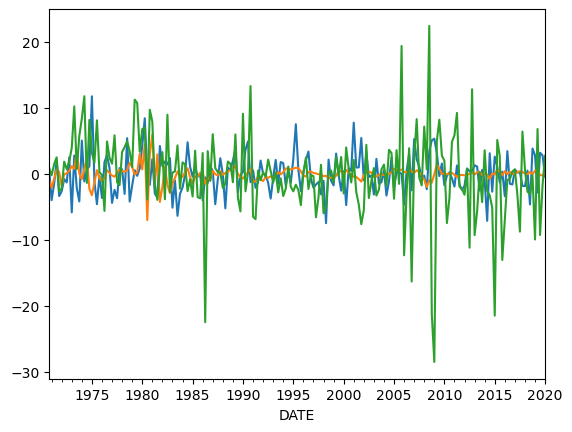

In [27]:
model=VAR(vardf)
results=model.fit(maxlags=2)
results.resid.unempgr.plot()
results.resid.dfedrate.plot()
results.resid.inflat.plot()

Text(0.5, 1.0, 'PACF for unempgr residuals')

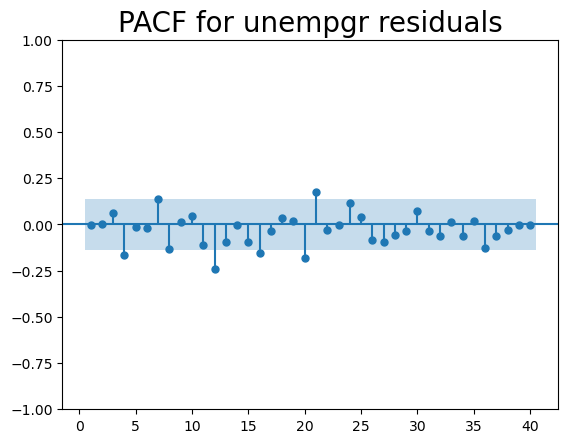

In [28]:
sgt.plot_pacf(results.resid.unempgr, lags=40, zero=False, method='ols')
plt.title("PACF for unempgr residuals", size=20)

Text(0.5, 1.0, 'PACF for federal fund rate residuals')

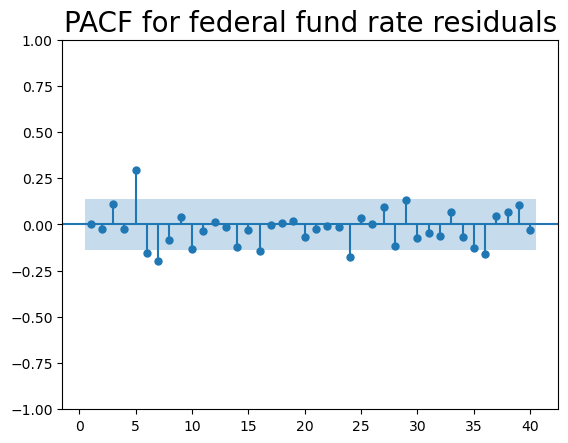

In [29]:
sgt.plot_pacf(results.resid.dfedrate, lags=40, zero=False, method='ols')
plt.title("PACF for federal fund rate residuals", size=20)

Text(0.5, 1.0, 'PACF for inflation residuals')

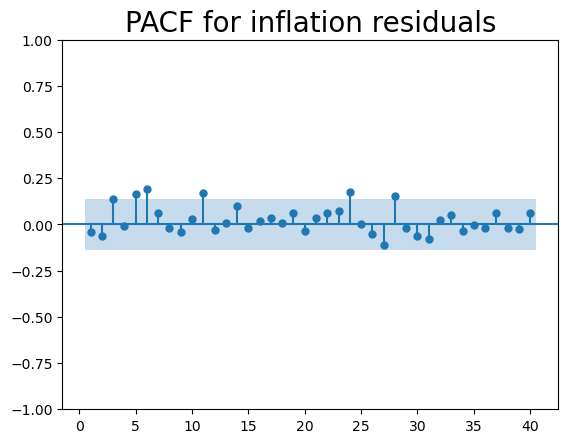

In [30]:
sgt.plot_pacf(results.resid.inflat, lags=40, zero=False, method='ols')
plt.title("PACF for inflation residuals", size=20)

## Splitting the data


In [31]:
train=vardf[:-8]
test=vardf[-8:]

model=VAR(train)
lags=2
results=model.fit(maxlags=lags)

In [32]:
train.tail()

,unempgr,dfedrate,inflat
DATE,,,
2017-01-31,0.000000,0.25,3.883701
2017-04-30,0.000000,0.25,0.089737
2017-07-31,0.000000,0.25,-5.410430
2017-10-31,-2.325581,0.00,8.386921
2018-01-31,-2.439024,0.26,5.352624


In [33]:
fcinput=train.values[-1*lags:]
fcinput

array([[-2.3255814 ,  0.        ,  8.386921  ],
       [-2.43902439,  0.26      ,  5.352624  ]])

In [34]:
fc=results.forecast(y=fcinput, steps=8)
fc

array([[-0.55810247,  0.29369278,  4.27590926],
       [-0.41812991,  0.00979064,  3.72952803],
       [-0.23954853, -0.0182216 ,  3.87110365],
       [-0.15718385, -0.00543899,  3.68391349],
       [-0.11919089, -0.02079846,  3.68307913],
       [-0.1118317 , -0.02681148,  3.68705595],
       [-0.10337891, -0.02557391,  3.68300479],
       [-0.10003758, -0.02629988,  3.68040715]])

In [35]:
df_fc=pd.DataFrame(fc, index=test.index, columns=test.columns)
df_fc

,unempgr,dfedrate,inflat
DATE,,,
2018-04-30,-0.558102,0.293693,4.275909
2018-07-31,-0.418130,0.009791,3.729528
2018-10-31,-0.239549,-0.018222,3.871104
2019-01-31,-0.157184,-0.005439,3.683913
2019-04-30,-0.119191,-0.020798,3.683079
2019-07-31,-0.111832,-0.026811,3.687056
2019-10-31,-0.103379,-0.025574,3.683005
2020-01-31,-0.100038,-0.026300,3.680407


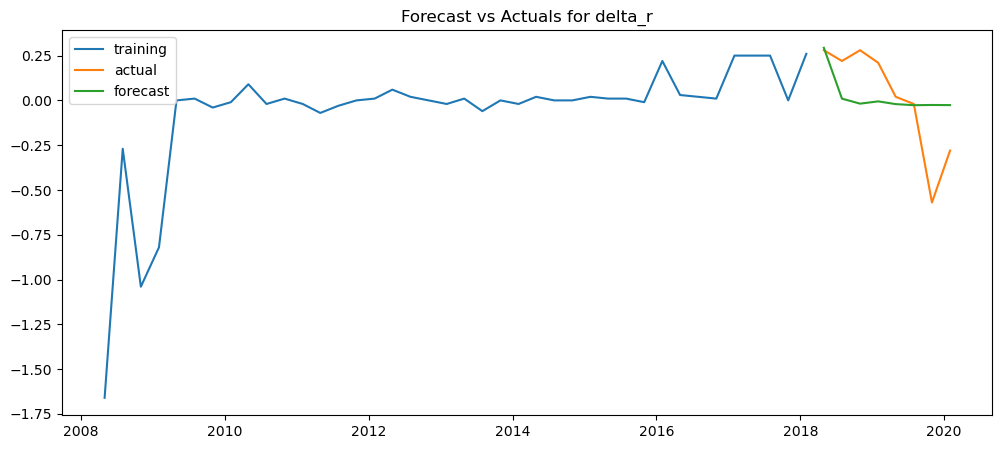

In [36]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.dfedrate[-40:], label='training')
plt.plot(test.dfedrate, label='actual')
plt.plot(df_fc.dfedrate, label='forecast')
plt.title('Forecast vs Actuals for delta_r')
plt.legend(loc='upper left', fontsize=10)

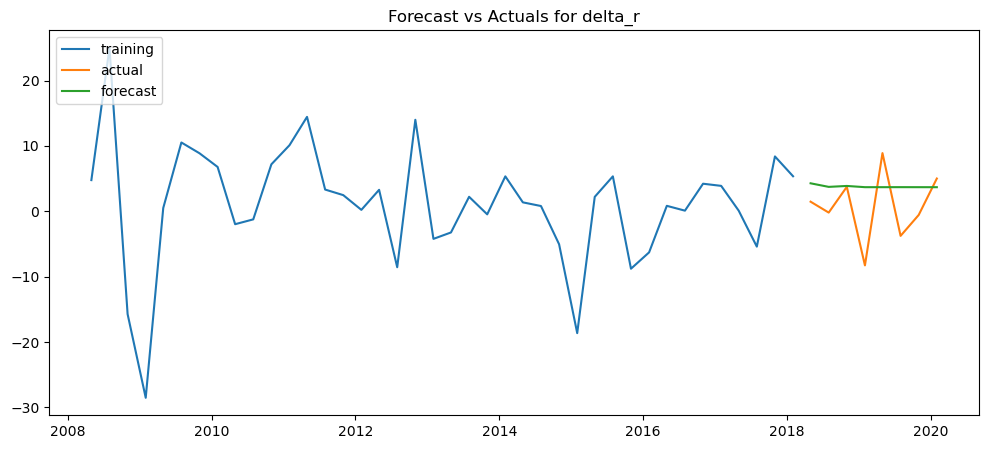

In [37]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.inflat[-40:], label='training')
plt.plot(test.inflat, label='actual')
plt.plot(df_fc.inflat, label='forecast')
plt.title('Forecast vs Actuals for delta_r')
plt.legend(loc='upper left', fontsize=10)

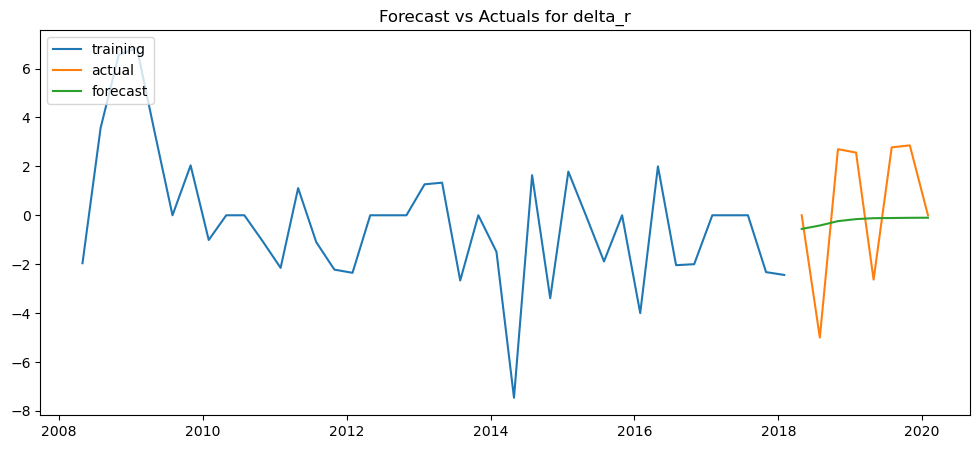

In [38]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.unempgr[-40:], label='training')
plt.plot(test.unempgr, label='actual')
plt.plot(df_fc.unempgr, label='forecast')
plt.title('Forecast vs Actuals for delta_r')
plt.legend(loc='upper left', fontsize=10)

In [39]:
# Invert the transformation (differencing) to get the real forecast
train['fedrate']=df.fedrate[1:-4]
test['fedrate']=df.fedrate[-4:]
df_fc['fedrate']=train.fedrate.iloc[-1]+df_fc.dfedrate.cumsum()
df_fc

/var/folders/gl/sc9s01490bg0vmyvzpbkn1lm0000gn/T/ipykernel_22263/1121422944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['fedrate']=df.fedrate[1:-4]
/var/folders/gl/sc9s01490bg0vmyvzpbkn1lm0000gn/T/ipykernel_22263/1121422944.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['fedrate']=df.fedrate[-4:]


,unempgr,dfedrate,inflat,fedrate
DATE,,,,
2018-04-30,-0.558102,0.293693,4.275909,1.703693
2018-07-31,-0.418130,0.009791,3.729528,1.713483
2018-10-31,-0.239549,-0.018222,3.871104,1.695262
2019-01-31,-0.157184,-0.005439,3.683913,1.689823
2019-04-30,-0.119191,-0.020798,3.683079,1.669024
2019-07-31,-0.111832,-0.026811,3.687056,1.642213
2019-10-31,-0.103379,-0.025574,3.683005,1.616639
2020-01-31,-0.100038,-0.026300,3.680407,1.590339


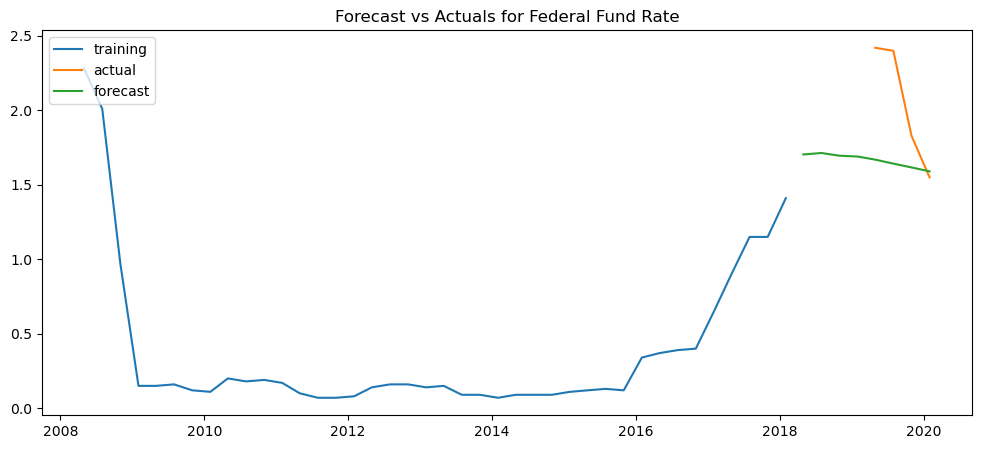

In [40]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.fedrate[-40:], label='training')
plt.plot(test.fedrate, label='actual')
plt.plot(df_fc.fedrate, label='forecast')
plt.title('Forecast vs Actuals for Federal Fund Rate')
plt.legend(loc='upper left', fontsize=10)

In [57]:
 def forecast_accuracy(forecast, actual):
     actual[actual == 0] = 0.0001  # replace zeros with 0.0001
     me = df.mean(forecast - actual)             # ME
     mae = df.mean(df.abs(forecast - actual))    # MAE
     mpe = df.mean((forecast - actual)/actual) 
     mape = df.mean(df.abs(forecast - actual)/df.abs(actual))  # MAPE
     rmse = df.mean((forecast - actual)**2)**.5  # RMSE
     return({ 'mape':mape, 'rmse':rmse})
 forecast_accuracy(fc[-8:], test.values)

ValueError: operands could not be broadcast together with shapes (8,3) (8,4) 

## Granger Causality

In [50]:
from statsmodels.tsa.stattools import grangercausalitytests

In [51]:
df_gc=pd.DataFrame({'dfedrate': df.dfedrate[1:], 'unempgr': df.unempgr[1:]})
df_gc.head()

,dfedrate,unempgr
DATE,,
1970-04-30,-0.88,4.545455
1970-07-31,-0.89,2.040816
1970-10-31,-1.01,1.851852
1971-01-31,-2.06,-3.278689
1971-04-30,0.02,-1.666667


In [52]:
gc_results=grangercausalitytests(df_gc,2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.3009 , p=0.0002  , df_denom=196, df_num=1
ssr based chi2 test:   chi2=14.5198 , p=0.0001  , df=1
likelihood ratio test: chi2=14.0145 , p=0.0002  , df=1
parameter F test:         F=14.3009 , p=0.0002  , df_denom=196, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.3630  , p=0.0008  , df_denom=193, df_num=2
ssr based chi2 test:   chi2=15.1076 , p=0.0005  , df=2
likelihood ratio test: chi2=14.5589 , p=0.0007  , df=2
parameter F test:         F=7.3630  , p=0.0008  , df_denom=193, df_num=2


In [53]:
df_gc2=pd.DataFrame({'dfedrate': df.dfedrate[1:],'inflat': df.inflat[1:]})
df_gc2.head()

,dfedrate,inflat
DATE,,
1970-04-30,-0.88,2.988400
1970-07-31,-0.89,2.820601
1970-10-31,-1.01,4.140483
1971-01-31,-2.06,2.385616
1971-04-30,0.02,3.513699


In [54]:
gc_results=grangercausalitytests(df_gc2,2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3744  , p=0.2425  , df_denom=196, df_num=1
ssr based chi2 test:   chi2=1.3954  , p=0.2375  , df=1
likelihood ratio test: chi2=1.3905  , p=0.2383  , df=1
parameter F test:         F=1.3744  , p=0.2425  , df_denom=196, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9520  , p=0.3878  , df_denom=193, df_num=2
ssr based chi2 test:   chi2=1.9533  , p=0.3766  , df=2
likelihood ratio test: chi2=1.9438  , p=0.3784  , df=2
parameter F test:         F=0.9520  , p=0.3878  , df_denom=193, df_num=2


In [55]:
df_gc3=pd.DataFrame({ 'unempgr': df.unempgr[1:],  'inflat': df.inflat[1:]})
df_gc3.head()

,unempgr,inflat
DATE,,
1970-04-30,4.545455,2.988400
1970-07-31,2.040816,2.820601
1970-10-31,1.851852,4.140483
1971-01-31,-3.278689,2.385616
1971-04-30,-1.666667,3.513699


In [56]:
gc_results=grangercausalitytests(df_gc3,2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2044  , p=0.2738  , df_denom=196, df_num=1
ssr based chi2 test:   chi2=1.2228  , p=0.2688  , df=1
likelihood ratio test: chi2=1.2191  , p=0.2695  , df=1
parameter F test:         F=1.2044  , p=0.2738  , df_denom=196, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0415  , p=0.3549  , df_denom=193, df_num=2
ssr based chi2 test:   chi2=2.1369  , p=0.3435  , df=2
likelihood ratio test: chi2=2.1255  , p=0.3455  , df=2
parameter F test:         F=1.0415  , p=0.3549  , df_denom=193, df_num=2


#### To address high levels of inflation, the Federal Reserve should consider raising interest rates or reducing the money supply to reduce spending and cool down the economy. On the other hand, to address high levels of unemployment, the Federal Reserve should consider lowering interest rates or increasing the money supply to stimulate spending and encourage hiring.